In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import datetime
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf

from tqdm.notebook import tqdm

from concurrent.futures import ThreadPoolExecutor

from importlib import reload
import best_model_creator
import sentinel_utils
import plot_utils
import ee_downloader
from data_generator import DataGenerator

In [2]:
figures_dir = Path('report', 'figures', 'figures_climate')

In [3]:
model_dir = Path('models', 'best_model')
model = tf.keras.models.load_model(model_dir.joinpath('model.keras'))

In [4]:
utils = sentinel_utils.SentinelUtils(
    min_occurrences=20000,
)
selected_classes = utils.get_processed_labels()

data_summary = utils.get_data_summary(
    selected_classes, 
    training_years='2017_2018_2019',
    overwrite_existing=False
)

In [5]:
weather_median = pd.read_csv(Path('weather_data', 'era5_2017.csv'))
weather_median = weather_median.interpolate(method='nearest').ffill().bfill()

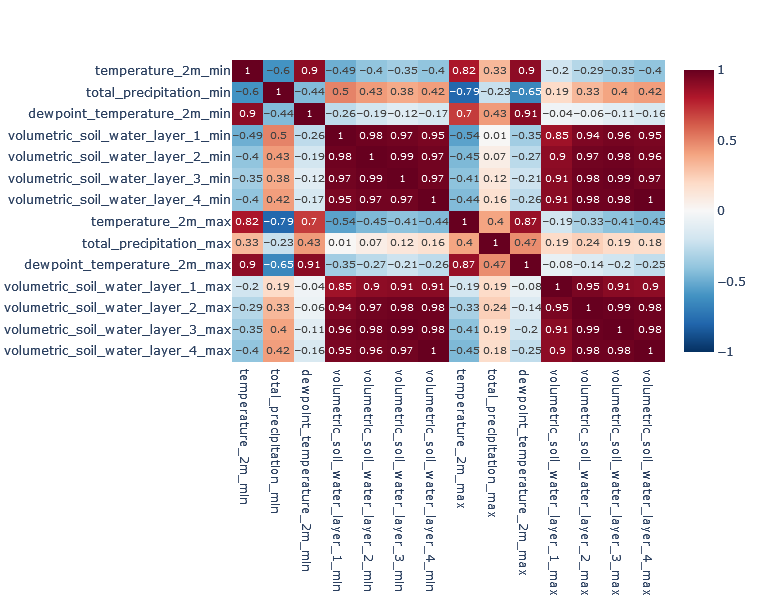

In [17]:
fig = px.imshow(
    weather_median.corr().round(2),
    text_auto=True, aspect='auto', zmin=-1, zmax=1,
    color_continuous_scale='RdBu_r',
    height=600,
)
fig.write_image(figures_dir.joinpath('weather_correlations.pdf'))
fig

In [7]:
select_variables = [
    'temperature_2m', 'total_precipitation', 'dewpoint_temperature_2m',
    'volumetric_soil_water_layer_2'
]

In [8]:
eval_years = list(range(2020, 2025))

weathers = []
weather_diffs = []

for eval_year in tqdm(eval_years):
    use_weather_cols = [s + m for s in select_variables for m in ['_max', '_min']]

    weather = pd.read_csv(Path('weather_data', f'era5_{eval_year}.csv'))
    weather = weather[use_weather_cols]
    
    weather = weather.interpolate(method='nearest').ffill().bfill()

    weather_diff = (
        (weather - weather_median[use_weather_cols])
        .loc[selected_classes.index]
    )
    weather_diffs.append(weather_diff)

    weather['year'] = eval_year
    weathers.append(weather)

  0%|          | 0/5 [00:00<?, ?it/s]

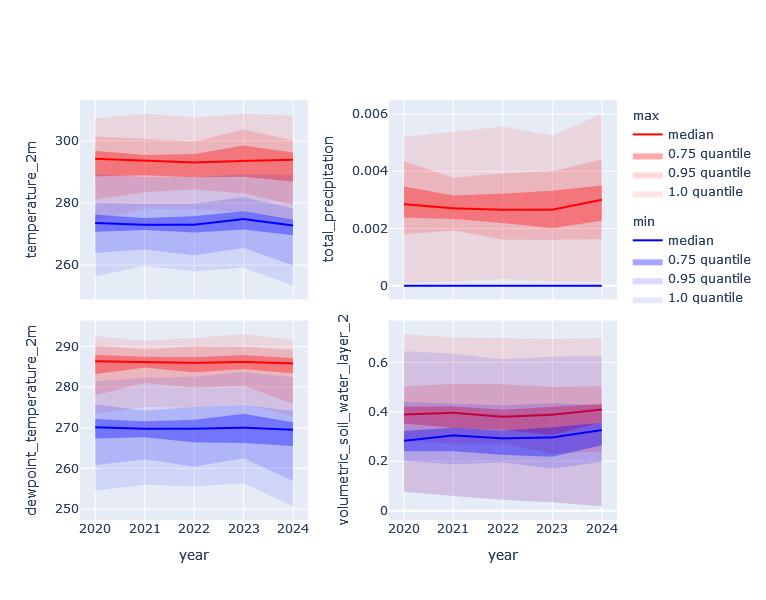

In [19]:
weathers_df = pd.concat(weathers)
nrows, ncols = 2, 2
fig = make_subplots(
    rows=nrows, cols=ncols,
    shared_xaxes='all',
    vertical_spacing=0.05,
    horizontal_spacing=0.15
)

yearly_weather = weathers_df.groupby('year')
x = weathers_df['year'].unique().tolist()

for i, variable in enumerate(select_variables):
    position = dict(row=(i//ncols)+1, col=(i%ncols)+1)
    for color, minmax in zip(['red', 'blue'], ['max', 'min']):
        median = yearly_weather[f'{variable}_{minmax}'].agg('median')
        fig.add_trace(go.Scatter(
            x=x,
            y=median,
            line_color=color,
            mode='lines',
            legendgroup=minmax,
            legendgrouptitle_text=minmax,
            name='median',
            showlegend=True if i == 0 else False
        ), **position)
        for quantile in [0.75, 0.95, 1.0]:
            upper_quantile = yearly_weather[f'{variable}_{minmax}'].quantile(quantile)
            lower_quantile = yearly_weather[f'{variable}_{minmax}'].quantile(1-quantile)
            fig.add_trace(go.Scatter(
                x=x+x[::-1],
                y=pd.concat([upper_quantile, lower_quantile[::-1]]),
                fill='toself',
                fillcolor=color,
                opacity=1.1-quantile,
                line_color='rgba(255,255,255,0)',
                hoverinfo='skip',
                legendgroup=minmax,
                name=f'{quantile} quantile',
                showlegend=True if i == 0 else False
            ), **position)
    fig.update_yaxes(title=variable, **position)
    fig.update_xaxes(title='year' if i > 1 else None, **position)

fig.update_layout(
    height=600
)
fig.write_image(figures_dir.joinpath('selected_variables_stats.pdf'))
fig

In [10]:
corrs = []

y_diffs = []

for i, eval_year in enumerate(tqdm(eval_years)):
    params = dict(
        selected_classes=selected_classes,
        data_summary=data_summary,
        model_dir=model_dir,
        batch_size=64,
        years=str(eval_year)
    )
    eval_generator = DataGenerator(
        selected_classes.index, shuffle=False, **params
    )
    preds_path = model_dir.joinpath(f'preds_{eval_year}.npy')
    if preds_path.is_file():
        y_pred = np.load(preds_path)
    else:
        y_pred = model.predict(x=eval_generator, verbose=1)
        np.save(preds_path, y_pred)

    y_true = selected_classes.to_numpy()[:y_pred.shape[0]]
    y_diff = pd.DataFrame(
        y_pred - y_true, 
        columns=selected_classes.columns
    )
    
    corr = pd.concat(
        [y_diff, weather_diffs[i].iloc[:y_pred.shape[0]]], axis=1, keys=['df1', 'df2']
    ).corr().loc['df2', 'df1'].round(2)

    y_diff['year'] = eval_year
    y_diffs.append(y_diff)
    
    corr['year'] = eval_year
    corrs.append(corr)

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
zmax = max([c.drop('year', axis=1).abs().max().max() for c in corrs])
fig = px.imshow(
    np.array([c.drop('year', axis=1) for c in corrs]),
    animation_frame=0,
    labels=dict(color='Pearson<br>coef.'),
    x=corrs[0].drop('year', axis=1).columns,
    y=corrs[0].drop('year', axis=1).index,
    title='Annual correlation heatmap',
    color_continuous_scale='RdBu_r',
    text_auto=True, aspect='auto', 
    zmin=-zmax, 
    zmax=zmax, 
    height=500
)
fig.layout.sliders[0]['currentvalue']['prefix'] = ''
for year, step in zip(eval_years, fig.layout.sliders[0].steps):
    step.label = str(year)

# fig.write_image(figures_dir.joinpath('climate_genus_corr.pdf'))
fig

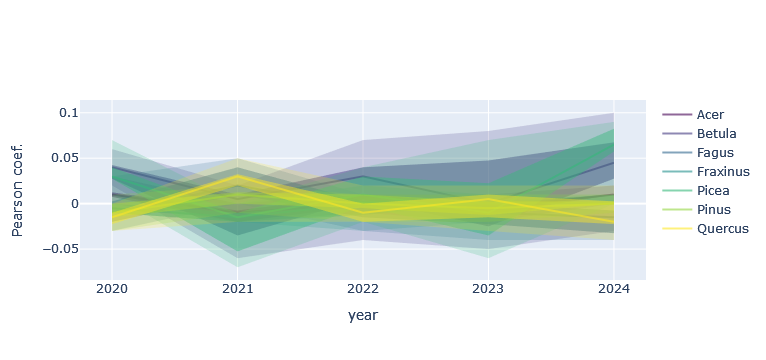

In [22]:
x = weathers_df['year'].unique().tolist()
yearly_corrs = pd.concat(corrs).groupby('year')

n_colors = corrs[0].drop('year', axis=1).columns.shape[0]
color_scale = px.colors.sample_colorscale('viridis', [n/(n_colors -1) for n in range(n_colors)])

fig = go.Figure()
for i, genus in enumerate(corrs[0].drop('year', axis=1).columns):
    fig.add_trace(go.Scatter(
        x=x,
        y=yearly_corrs[genus].agg('median'),
        line_color=color_scale[i],
        mode='lines',
        opacity=0.6,
        name=genus,
        showlegend=True
    ))
    for quantile in [0.75, 1.0]:
        upper_quantile = yearly_corrs[genus].quantile(quantile)
        lower_quantile = yearly_corrs[genus].quantile(1-quantile)
        fig.add_trace(go.Scatter(
            x=x+x[::-1],
            y=pd.concat([upper_quantile, lower_quantile[::-1]]),
            fill='toself',
            fillcolor=color_scale[i],
            opacity=1.2-quantile,
            line_color='rgba(255,255,255,0)',
            hoverinfo='skip',
            showlegend=False
        ))
fig.update_layout(
    xaxis_title='year', yaxis_title='Pearson coef.'
)
fig.write_image(figures_dir.joinpath('genus_corr.pdf'))
fig

In [13]:
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler

min_occurrences = 20000
scores_path = Path('tmp', 'scores_weather_classification.npy')
predictions_path = Path('tmp', 'predictions_weather_classification.npy')

if scores_path.is_file() and predictions_path.is_file():
    scores_array = np.load(scores_path)
    predictions_array = np.load(predictions_path)
else:
    x_input = Input((weather_diff.shape[-1],))
    
    for units in [512, 256, 128]:
        x = Dense(units, activation='leaky_relu')(x_input)
        x = Dropout(0.2)(x)
    
    outputs = Dense(1, activation='leaky_relu')(x)
    
    all_scores = []
    all_predictions = []
    for weather_diff, y_diff in tqdm(list(zip(weather_diffs, y_diffs))):
        scores = []
        predictions = []
        for genus in tqdm(y_diff.drop('year', axis=1).columns, leave=False):
            m = tf.keras.models.Model(
                inputs=[x_input], outputs=outputs
            )
            m.compile(
                optimizer='adam', loss='huber', 
                metrics=[
                    'mean_absolute_error', 
                    'mean_absolute_percentage_error', 
                    'r2_score'
                ]
            )
            hist = m.fit(
                x=StandardScaler().fit_transform(
                    weather_diff.iloc[:y_diff.shape[0]]
                ), 
                y=y_diff[[genus]],
                validation_split=0.1,
                epochs=10, verbose=0
            )
            scores.append([
                hist.history['val_r2_score'][-1],
                hist.history['val_mean_absolute_error'][-1],
                hist.history['val_mean_absolute_percentage_error'][-1],
                hist.history['val_loss'][-1]
            ])

            prediction = m.predict(
                x=StandardScaler().fit_transform(
                    weather_diff.iloc[:y_diff.shape[0]]
                ))
            predictions.append(prediction)
        all_scores.append(scores)
        all_predictions.append(predictions)
        
    scores_array = np.array(all_scores)
    np.save(scores_path, scores_array)

    predictions_array = np.transpose(np.array(all_predictions)[..., 0])
    np.save(predictions_path, predictions_array)

In [14]:
residuals = []
for i, y_diff in enumerate(y_diffs):
    res = y_diff.drop('year', axis=1) - predictions_array[:, :, i]
    residuals.append(res)

residuals = np.stack(residuals, axis=-1)

In [24]:
high_r2 = scores_array
# high_r2 = high_r2.T[(r2_scores.mean() > 0.2).values].T
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    horizontal_spacing=0.15,
)
dashes = ['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot']*20

residuals_n = 50000
for i, col in enumerate(y_diff.drop('year', axis=1).columns.tolist()):
    for ii, metric in enumerate(['R<sup>2</sup>', 'MAE']):
        fig.add_trace(go.Scatter(
            x=eval_years,
            y=high_r2[:, i, ii],
            line_color=color_scale[i],
            name=col,
            mode='lines',
            showlegend=True if ii == 0 else False,
            line_dash=dashes[i],
        ), row=1, col=ii+1)

    fig.add_trace(go.Scatter(
        x=shuffle(predictions_array[:, i, -1], random_state=42, n_samples=residuals_n),
        y=shuffle(residuals[:, i, -1], random_state=42, n_samples=residuals_n),
        showlegend=False,
        marker_color=color_scale[i],
        mode='markers',
        opacity=0.5,
        marker_size=1,
    ), row=2, col=1)
    
fig.update_layout(
    yaxis3_title='expected - predicted',
    yaxis2_title='MAE',
    yaxis1_title='R<sup>2</sup>',
    xaxis2_title='year',
    xaxis1_title='year',
    xaxis3_title='predicted',
    yaxis_title_standoff=1,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    hovermode=False,
    height=600
)
fig.write_image(figures_dir.joinpath('regression_results.png'), scale=5)
# fig